# Dobble explained

### Marco Giunta, 3/4/2021 - 7/4/2021

In [1]:
library("curl")
library("RCurl")
library("IRdisplay")

# Introduzione
## Il gioco di carte
*Dobble* (chiamato "*Spot it!*" in alcuni paesi) è un gioco basato su 55 carte, ciascuna delle quali contiene 8 simboli fra 57 possibili. Il manuale del gioco spiega le regole di 5 diversi minigiochi basati su questo mazzo; tutti si basano sulla rapidità da parte del giocatore nell'individuare i due simboli in comune fra due qualunque carte del mazzo. Questa è la particolarità "magica" del gioco: *prese due qualunque carte queste avranno sempre esattamente uno e un solo simbolo in comune*. È facile immaginarsi come costruire andando a tentativi un mazzo composto da poche carte con poche figure, ma quando i numeri diventano "grandi" (50+ nel nostro caso) sembra quasi incredibile che questo sia possibile; soprattutto giocando al gioco è alquanto incredibile e divertente la dissonanza cognitiva fra l'istintivo "non sto riuscendo a trovare una coppia, quindi non esiste" e la nozione di "deve esistere sempre una e una sola coppia di figure condivise fra due carte qualunque".            

## Obiettivi di questo notebook
Sorgono spontanee diverse domande:
- Com'è possibile questa magia?
- Come hanno fatto a progettare le carte presenti nella scatola? Magari andando a tentativi (ad esempio con un codice in stile "accept-reject" che tenga conto delle combinazioni già create) è possibile creare un mazzo piccolo, ma sembra difficile usare questo approccio per un mazzo di 50+ carte. In particolare: esiste un algoritmo deterministico (più efficiente di un approccio stocastico) per replicare il mazzo presente del gioco? 
- Esiste un legame deterministico fra i numeri in gioco (55 carte, 57 figure, 8 figure per carta)? Avrebbero potuto mettere più carte mantenendo fissato il numero di simboli (eccetera)?
- È possibile costruire mazzi più piccoli/grandi utilizzando le risposte alle domande precedenti?            

Il mistero è particolarmente intrigante perché un biglietto nella scatola menziona che il gioco "dietro le quinte" funzioni grazie al 
> "principio di interazione secondo cui due linee hanno sempre un singolo punto in comune" (cit.)    

e alle strutture note come "schemi a blocchi bilanciati e incompleti" (utilizzati ad esempio nella teoria sui codici di correzione degli errori) in modo da generalizzare il "problema delle studentesse di Kirkman". Prima di scoprire Dobble conoscevo abbastanza geometria e le basi della teoria sui codici di correzione degli errori (bit di parità nei codici Hamming e Reed-Solomon), ma su due piedi mi sembravano mondi lontanissimi; inoltre non conoscevo niente degli altri argomenti citati, quindi l'opportunità di scoprire cose nuove grazie a Dobble è un bonus interessante (che però resta in qualche modo secondario alla curiosità di svelare il mistero della prima domanda scritta sopra).

## Note tecniche
Per rispondere alle domande di cui sopra stando alle mie ricerche servono:
- geometria proiettiva e algebra lineare (che ho studiato in triennale e conosco discretamente);
- cenni di algebra astratta: campi, anelli, algebra modulare, campi di Galois (di cui prima di Dobble avevo solo sentito nominare o letto di sfuggita);
- *piani proiettivi finiti* e matrici di incidenza come applicazione degli schemi a blocchi, i principali protagonisti del gioco (cose che non avevo mai sentito né avrei mai incontrato senza Dobble, probabilmente).    
Per quanto riguarda gli ultimi punti, dunque, sono tutt'altro che un esperto, quindi invito il lettore ad avere spirito critico, a leggere le fonti che propongo e a trarre le sue conclusioni - mentre imho riguardo la mia spiegazione della geometria proiettiva ti puoi fidare, caro lettore!

# Geometria proiettiva
## Cosa non dice il biglietto sulla codifica dell'informazione?
Partiamo dalla citazione sopra riportata del manuale di gioco. È immediato trarre la seguente conclusione: *se riusciamo ad associare ogni carta ad una retta e ogni punto ad una figura "abbiamo finito"*, in quanto l'intersezione di due rette in un dato punto equivale al fatto che quelle due carte condividano quella particolare figura; è facile intuire perché questo modo di modellizzare il problema sia promettente (ad esempio il fatto che due rette incidenti si incontrino in un solo punto immediatamente spiegherebbe perché due carte non abbiano più di un simbolo in comune), ma è altrettanto facile capire perché questa codifica dell'informazione sia altamente non banale.    
Esempio: il nostro problema è intrinsecamente discreto (un numero intero positivo di carte e figure), mentre le rette e i punti del piano sono oggetti continui, descritti da numeri reali; come si possono conciliare questi due aspetti? Se volessimo codificare l'informazione sulle figure in una carta nei 2 coefficienti reali della retta (ad esempio sfruttando un numero fissato e basso di bit nella float representation) introdurremmo degli errori che ad istinto sembrano fuori luogo (probabilmente esiste un algoritmo esatto), oppure dovremmo associare le figure non tanto a dei punti quanto piuttosto a delle regioni di piano (che sembra altrettanto fuori luogo).      
C'è però un problema ancora più grave: *non è vero che due rette hanno sempre un punto in comune!* Basta infatti che due rette siano parallele affinché quello che sembra essere il nostro assunto fondamentale fallisca miseramente. Che si fa, dunque? Si escludono rette parallele ad hoc? Il mio senso estetico mi dice che debba esserci un altro modo di procedere.    

Risolviamo innanzitutto il secondo problema, più fondamentale del primo (e del quale immaginavo già la risposta grazie ai miei studi); fatto ciò potremo discutere come affrontare in modo soddisfacente l'altro problema appena sollevato.     

## Coordinate omogenee, punti impropri
Quanto segue può essere studiato in dimensione arbitraria, ma per concretezza ci concentriamo sul familiare piano euclideo (che basta e avanza per i nostri scopi).      
Com'è noto il piano euclideo può essere messo in corrispondenza con $\mathbb{R}^2$ associando ad ogni punto una coppia di numeri, che ne rappresentano le coordinate rispetto ad un opportuno sistema di riferimento. Questa identificazione può essere sviluppata al livello "ingenuo" della geometria analitica da liceo se ci limitiamo ad associare equazioni algebriche a rette, piani eccetera; possiamo però "tradurre" la ben nota geometria euclidea nel linguaggio dell'algebra vettoriale in modo sistematico e soddisfacente, che permette di abbandonare dimostrazioni complicate basate su costruzioni esotiche in favore di concetti ben più abbordabili per la gente normale (matrici, autovettori, eccetera). Esistono almeno due strade per effettuare questo lavoro: la *geometria affine* e la *geometria proiettiva*, che sono strettamente correlate - qui ci limitiamo a discutere la seconda, menzionando solamente la prima.

## Dalla geometria affine...
È semplice immaginarsi che la struttura di spazio vettoriale sia il modo vincente di "algebrizzare" la geometria euclidea: lo stesso insieme $\mathbb{R}^2$ usato per tradurre punti in coppie di numeri può essere dotato della struttura di spazio vettoriale sul campo reale; in particolare una volta che sia stato fissato un sistema di coordinate la geometria euclidea soddisfa naturalmente gli assiomi degli spazi vettoriali (come è evidente sfruttando l'isomorfismo di cui sopra). In effetti c'è una sottigliezza: gli assiomi degli spazi vettoriali si basano sul fatto che esista un vettore nullo che sia in qualche modo privilegiato - il che presuppone necessariamente che fissiamo una origine in modo arbitrario, e questo costituisce una "forzatura" rispetto alla geometria che Euclide probabilmente disegnava per terra. La geometria affine si occupa di sistemare questa incongruenza introducendo gli *spazi affini*, insiemi costituiti da oggetti detti *punti* ed una applicazione $\varphi$ tali che quest'ultima associ ad ogni coppia di punti un elemento di un dato spazio vettoriale. L'idea, quindi, è che due punti $P$ e $Q$ qualunque si possa costruire il vettore $\varphi(P,Q) = P-Q$ che rappresenti $P$ nel riferimento centrato su $Q$; in questo modo possiamo usare gli strumenti dell'algebra lineare senza introdurre una origine privilegiata in modo univoco. Non perseguiamo ulteriormente l'argomento in quanto vogliamo saltare direttamente alla geometria proiettiva, "potenziamento" di quella affine; ci basti sottolineare che mediante questa associazione è possibile associare strettamente le nozioni della geometria euclidea (lunghezze, angoli, intersezioni, parallelismo) in controparti basate sull'algebra lineare.

## ...a quella proiettiva!
Adesso che abbiamo chiaro come trattare algebricamente concetti geometrici dedichiamoci al problema delle rette parallele, e in particolare alla asimmetria fra rette parallele e non.     
Sappiamo che nella geometria euclidea due rette qualunque possono avere uno o nessun punto in comune; a seconda che accada l'una o l'altra possibilità le rette si dicono parallele o meno (e come anticipato questo è un potenziale ostacolo alla soluzione del nostro problema).    
La geometria proiettiva scioglie questa asimmetria introducendo un nuovo tipo di punti, detti *punti impropri*, in modo tale che due rette non parallele abbiano in comune un punto proprio mentre due rette parallele condividano un punto improprio; per introdurre questi punti abbiamo bisogno di introdurre le cosiddette coordinate omogenee come segue.      
Supponiamo che il punto $P$ sia descritto dal vettore $(x,y)\in\mathbb{R}^2$; chiamiamo *coordinate non omogenee* quelle in cui il punto $P$ è rappresentato da questa coppia unica di numeri reali. Diremo che il punto $P$ è rappresentato anche dalle *coordinate omogenee* $(x',y',t')$ così definite:
\begin{equation}
x = \frac{x'}{t'}, \quad y = \frac{y'}{t'}
\end{equation}
È immediato notare come *le coordinate omogenee di un punto non siano definite univocamente*: stando alla definizione di cui sopra i vettori $(x',y',t')$ e $\lambda (x',y',t')$ (con $\lambda\neq 0$ scalare arbitrario appartenente al campo su cui è definito lo spazio vettoriale) rappresentano lo stesso punto. Questo fatto è alquanto intuitivo: stiamo lavorando con oggetti bidimensionali, ma li stiamo descrivendo con una coordinata "di troppo"; tuttavia in seguito sarà fondamentale nel ricavare la legge che lega i numeri del gioco.      
Stando alla definizione appena data, dunque, il punto $(1,1)$ potrà essere descritto ugualmente bene dalle terne $(1,1,1)$, $(\pi,\pi,\pi)$ o $(0.5,0.5,0.5)$; l'importante è che si abbia sempre $t'\neq 0$, altrimenti abbiamo una divisione "proibita" nella definizione data sopra.     
Possiamo spiegare facilmente il nome di queste coordinate; ad esempio la retta $ax+by+c=0$ in coordinate omogenee diventa:
\begin{equation}
a\left(\frac{x'}{t'}\right)+c\left(\frac{y'}{t'}\right)+c=0 \iff ax'+by'+ct'=0
\end{equation}
cioè adesso la nostra retta è descritta da una equazione *omogenea*, composta solo da termini dello stesso ordine; risultati analoghi valgono ad esempio per le coniche, che adesso possiamo definire come un insieme di punti che soddisfano una equazione omogenea di secondo grado (in quanto i termini lineari/costanti vengono moltiplicati per $t'$ o $t'^2$). Questa proprietà è già interessante e utile computazionalmente, ma la vera ricchezza introdotta dalle coordinate omogenee è quella di poter definire i punti impropri.       
Come detto sopra i punti del piano euclideo sono caratterizzati dall'avere $t'=0$; introduciamo pertanto dei nuovi punti, detti impropri, che siano della forma $(x,y,0)$ (avendo omesso l'apice per brevità). È chiaro che questi punti non abbiano senso in coordinate non omogenee, ma in geometria proiettiva ci dimentichiamo delle coordinate vecchie e arricchiamo volutamente il piano euclideo con punti nuovi (alquanto difficili da immaginare o rappresentare in modo soddisfacente).      
Si noti che se la terza coordinata di un punto improprio è per definizione zero allora questa non può essere resa non nulla moltiplicando il punto per uno scalare (ovviamente); questo significa che anche tenendo conto della ambiguità intrinseca delle coordinate omogenee non è possibile "confondere" punti propri e impropri, in quanto questi sono ben distinti. L'unico problema si avrebbe in corrispondenza del punto $(0,0,0)$; a quest'ultimo in geometria proiettiva non si associa alcun significato - si noti che non stiamo dicendo che l'origine vada eliminata in quanto questa corrisponde a $(0,0,\lambda) \ \forall \lambda\neq 0$, ma solo che le tre coordinate non possono annullarsi contemporaneamente (pena la perdita di significato).      

## La retta impropria e i punti impropri di ogni retta 
Viste le definizione di cui sopra è chiaro che l'equazione $t=0$ rappresenti il luogo dei nuovi punti introdotti (la cui natura va ancora chiarita). Che succede se calcoliamo l'intersezione di questo oggetto con una generica retta? Poiché siamo in coordinate omogenee otteniamo un sistema algebrico lineare omogeneo di due equazioni in 3 incognite:
\begin{equation}
ax+by+ct=0 \ \bigcap \ t=0
\end{equation}
(non so come caricare su Jupyter pacchetti $\LaTeX{}$ esterni e quindi non so scrivere un sistema di equazioni in modo corretto)       
Com'è noto questo significa che la soluzione $(x_0,y_0,0)$ è determinata a meno di una costante di proporzionalità arbitraria; tuttavia visto che in coordinate omogenee un punto è definito proprio a meno di una costante moltiplicativa arbitraria questo significa che le infinite soluzioni del sistema precedente rappresentano un unico punto improprio. Otteniamo un primo importante risultato: *ogni retta ha un punto improprio* (in aggiunta agli infiniti punti propri che aveva anche in geometria affine); di conseguenza possiamo dare al luogo $t=0$ il nome di *retta impropria*, in quanto rappresenta l'unione dei punti impropri di tutte le rette del piano (ciascuna delle quale interseca la retta impropria solo nel proprio punto improprio).    

## Punti impropri e rette parallele
Supponiamo adesso di considerare due rette non parallele/parallele tornando al vecchio sistema di coordinate; il sistema che si ottiene ammette soluzione solo se queste non sono parallele. Infatti se scriviamo l'equazione di una retta nella forma $y=mx+q$ otteniamo immediatamente che la soluzione (dunque l'intersezione) è $x_0=(q_2-q_1)/(m_1-m_2)$, che evidentemente non è definita se le due rette sono parallele (cioè se $m_1=m_2$). Geometricamente questo significa che le due rette non si incontrano o (come si dice "poeticamente") che si incontrano all'infinito (nozione che possiamo in qualche modo formalizzare considerando non $m_1=m_2$ ma $m_1\to m_2$).      
Che succede se ripetiamo lo stesso calcolo in coordinate omogenee? Adesso le due rette $a_1x+b_1y+c_1t=0$ e $a_2x+b_2y+c_2t=0$ possono avere $a_1=a_2, \ b_1=b_2$ (ma $c_1\neq c_2$, altrimenti è la stessa retta) *e ancora incontrarsi in un punto* - basta che la soluzione abbia $t=0$. Come detto prima questa soluzione algebricamente è definita a meno di una costante, ma geometricamente è unica; notiamo inoltre che si tratta evidentemente di un *punto improprio*. Otteniamo così il fondamentale risultato della geometria proiettiva: *due rette non parallele si incontrano in un punto proprio, due rette parallele si incontrano nel loro punto improprio* - e pertanto in geometria proiettiva non esistono più le rette parallele intese come "rette che non si incontrano in alcun punto". Perseguendo l'analogia delle rette parallele che si incontrano "all'infinito" visto che adesso sappiamo che due rette parallele si incontrano in un punto improprio possiamo rappresentare i punti impropri come punti "infinitamente lontani"; per questo motivo la retta impropria viene anche detta *retta all'infinito* - analogamente in dimensioni superiori si introducono il piano all'infinito, la conica all'infinito e così via, importanti aggiunte alla geometria euclidea di base. La retta impropria, pertanto, viene spesso rappresentata come una specie di cerchio di raggio infinito; questo è discretamente soddisfacente perché l'intuizione ci dice che i punti "al finito" sono "al completo", e quindi se vogliamo aggiungere dei punti nuovi dobbiamo metterli "all'infinito". Questo spiega anche il nome "geometria proiettiva", in quanto questa trae le sue origini dagli studi prospettici sulle proeizioni all'infinito (si pensi all'illusione visiva secondo cui i binari del treno diventano sempre più vicini fino a toccarsi all'orizzonte proprio come due rette parallele si toccano non appena raggiungono la retta "all'infinito").

## Significato "fisico" del punto improprio di una retta 
Abbiamo visto che due rette parallele (in senso euclideo) condividono il proprio punto improprio, che è una novità della geometria proiettiva. In effetti anche nella geometria euclidea (meglio: affine) di base queste condividevano qualcosa - la pendenza! Possiamo dimostrare facilmente che questa non è una coincidenza, e che in particolare il punto improprio di una retta codifica l'informazione sulla pendenza di una retta; questo ci fa capire algebricamente perché la soluzione del sistema di cui sopra sia impropria e lo sia proprio quando $m_1=m_2$.   
Per quanto sopra il punto improprio della retta $ax+by+c=0$ si ottiene intersecando quest'ultima con la retta impropria $t=0$, cioè risolvendo l'equazione $ax+by=0$ (equivalente al sistema iniziale). Questa ammette infinite soluzioni della forma $(x, (-a/b)x, 0)$; che $x$ sia arbitrario non è un problema come già ribadito più volte. Notiamo dunque che a meno di costanti $P_\infty = (1,(-a/b),0)$, e $-a/b$ è esattamente il coefficiente angolare $m$ della equazione in forma implicita della retta; evidentemente il quadro teorico che stiamo costruendo sta in piedi abbastanza bene.

## Punti impropri e Dobble
Abbiamo risolto così parte del problema: purché lavoriamo in coordinate omogenee e includiamo la retta all'infinito possiamo sempre garantire che due rette abbiano **sempre** uno e un solo punto in comune, e pertanto identificare carte con rette e figure con punti può funzionare in modo naturale (a patto di risolvere il secondo problema). Dobbiamo però risolvere il problema del discreto vs continuo; per farlo riassumiamo quello che abbiamo trovato finora.     
Possiamo assiomatizzare quanto trovato finora con qualche posizione "di alto livello"; in particolare ci diamo i seguenti assiomi.          
1) Dati due punti qualunque esiste sempre una e una sola retta che li attraversa entrambi.
2) Date due rette qualunque queste si incontrano sempre in uno e un solo punto.         
3) Esiste un insieme di 4 punti tali che nessuna terna di questi giaccia sulla stessa retta (questo serve solo per evitare geometrie finite banali, lo scrivo per completezza ma possiamo ignorarlo).       
In aggiunta ai precedenti assiomi mettiamo il quarto punto non ufficiale: la realizzazione "numerica" concreta degli assiomi precedenti avviene mediante il formalismo delle coordinate omogenee appena introdotto.

## Un appunto per il lettore curioso
I punti impropri non esauriscono la propria utilità con le rette. Ad esempio si dimostra che se aggiungiamo ancora altri punti (permettendo a questi nuovi punti di avere coordinate complesse) una conica qualunque ha due punti impropri, e questi la definiscono! In geometria proiettiva, infatti, possiamo definire l'ellisse come la conica con due punti impropri immaginari puri, l'iperbole come la conica con due punti impropri reali distinti, e la parabola come la conica con due punti impropri reali coincidenti; questo è utile per identificare una conica dall'equazione non in forma canonica senza necessità di effettuare la rototraslazione che ci dia coordinate rispetto alle quali la conica sia in forma canonica - ci risparmiamo così diagonalizzazioni di matrici eccetera. Se passiamo allo spazio tridimensionale il discorso diventa ancora più interessante: l'intersezione di una quadrica con il piano all'infinito produce la sua conica all'infinito, che (insieme all'informazione sulla natura dei punti della quadrica, desumibile da certi teoremi sulla tangenza con i piani) permette ancora una volta di dedurne la natura senza calcoli complicati o geogebra. I punti impropri servono anche per definire la *polarità*, una particolare dualità fra punti e rette del piano, che permette ad esempio di dimostrare che una retta per il centro di simmetria di una ellisse/iperbole individua sempre due tangenti parallele senza fare mezzo disegno...



# Piani proiettivi finiti
## Relazione di incidenza
Prima di procedere stabiliamo una nuova parola: anziché dire che un piano giace su una retta/che una retta passa per un piano diciamo che un punto/una retta e una retta/un punto sono incidenti; in questo modo possiamo evidenziare meglio la simmetria fra punti e rette, che ci tornerà utile a breve in quanto sfrutteremo la dualità fra questi. Non solo: l'insieme che vogliamo considerare ora è definito dagli oggetti che contiene e da una opportuna *relazione di incidenza* - che nel nostro caso è l'attraversamento di una retta in un punto.

## Piani con numeri finiti di punti e rette
Per risolvere il problema della discretezza del gioco abbiamo bisogno di considerare un piano che contenga *solo un numero finito di rette e punti*; insiemi di questo tipo vengono detti *piani finiti*. Anticipiamo fin da subito che un piano finito si dice di ordine $n$ se ogni retta è incidente con $n+1$ punti, ogni punto con $n+1$ rette e sono presenti $n^2+n+1$ punti e rette; discutiamo adesso più propriamente questi piani.                  
Supponiamo di voler costruire un insieme dotato di un certo numero *finito* di oggetti detti punti e altrettante rette (sempre in numero finito); affinché questo insieme si comporti come un piano abbiamo bisogno che soddisfi gli stessi assiomi soddisfatti dal piano euclideo tradizionale, e cioè che ogni coppia di punti/rette individui una sola retta/un solo punto. Questo significa che dobbiamo in linea di principio costruire un grafo che unisca punti e rette in modo che vengano soddisfatti questi assiomi; questo compito è reso più semplice ricorrendo alla teoria degli *schemi a blocchi*.

## Matrice di incidenza, schemi a blocchi

Supponiamo di costruire una matrice in modo tale che ogni riga sia associata ad un punto, mentre ogni colonna ad una retta (o viceversa, i piani finiti sono esempi di schemi a blocchi simmetrici); mettiamo 1 dove si ha incidenza fra il punto e la retta associati a quella riga e colonna, 0 altrove. Osserviamo dunque un vantaggio cruciale di questa rappresentazione: *se due qualunque punti devono essere attraversati da una e una sola retta allora due qualunque righe possono avere un 1 nella stessa colonna solo una volta* - e analogamente *se per rispettare gli assiomi che vogliamo imporre due rette qualunque devono toccarsi in uno e un solo punto allora una coppia arbitraria di colonne può avere un 1 nella stessa riga solo una volta*. Evidentemente stiamo costruendo una specie di sudoku (che in verità è un altro esempio di schema a blocchi): dobbiamo riempire una griglia di numeri in modo tale che la frequenza degli stessi soddisfi certe regole in merito alla popolazione di righe e colonne. La matrice in questione si chiama *matrice di incidenza*, e verrà calcolata esplicitamente nel caso di Dobble più avanti. Osserviamo adesso che la matrice di incidenza che soddisfa queste regole non può essere costruita per valori arbitrari dell'ordine del piano finito; per ricavare dei vincoli sui piani finiti osserviamo che essi sono un caso particolare di oggetti più generali chiamati *schemi a blocchi bilanciati e incompleti* (e in particolare si tratta di 2-design simmetrici). Senza scendere troppo nei dettagli basti dire che questi schemi altro non sono che strutture di incidenza formate da un insieme di oggetti e sottoinsiemi di questi oggetti costruiti in modo tale da soddisfare certe condizioni. Non ho capito molto dell'argomento, se non che fare avanti e indietro fra piani finiti e schemi a blocchi sia fruttuoso; ad esempio si può dimostrare [l'impossibilità](http://pi.math.cornell.edu/~web4520/CG-9-F2017.pdf) di costruire piani finiti per certi valori dell'ordine sulla base del fatto che non è possibile soddisfare [i vincoli necessari](https://en.wikipedia.org/wiki/Block_design) a costruirne lo schema (questi stessi vincoli determinano il numero $n^2+n+1$ menzionato prima, vedi la stessa pagina di wikipedia). Qui riporto solamente che se $n$ è la potenza di un numero primo la costruzione del piano è sempre possibile, mentre se non lo è si sa se sia possibile o meno solo per certi valori (ad esempio per 2 si può, per 6 no, ma oltre il 10 non si sa più niente di certo).     
Ricapitolando per costruire un piano finito di ordine $n$ ci serve una matrice che:
- abbia $n+1$ volte 1 in ogni riga;
- abbia $n+1$ volte 1 in ogni colonna;
- abbia uno e un solo 1 in comune per ogni coppia di righe;
- abbia uno e un solo 1 in comune per ogni coppia di colonne.
Trovata questa matrice (se esiste) avremo che il punto associato ad una data riga è attraversato dalle $n+1$ rette associate alle colonne contenenti gli 1 presenti in quella riga, e possiamo rappresentare il piano in questione. 

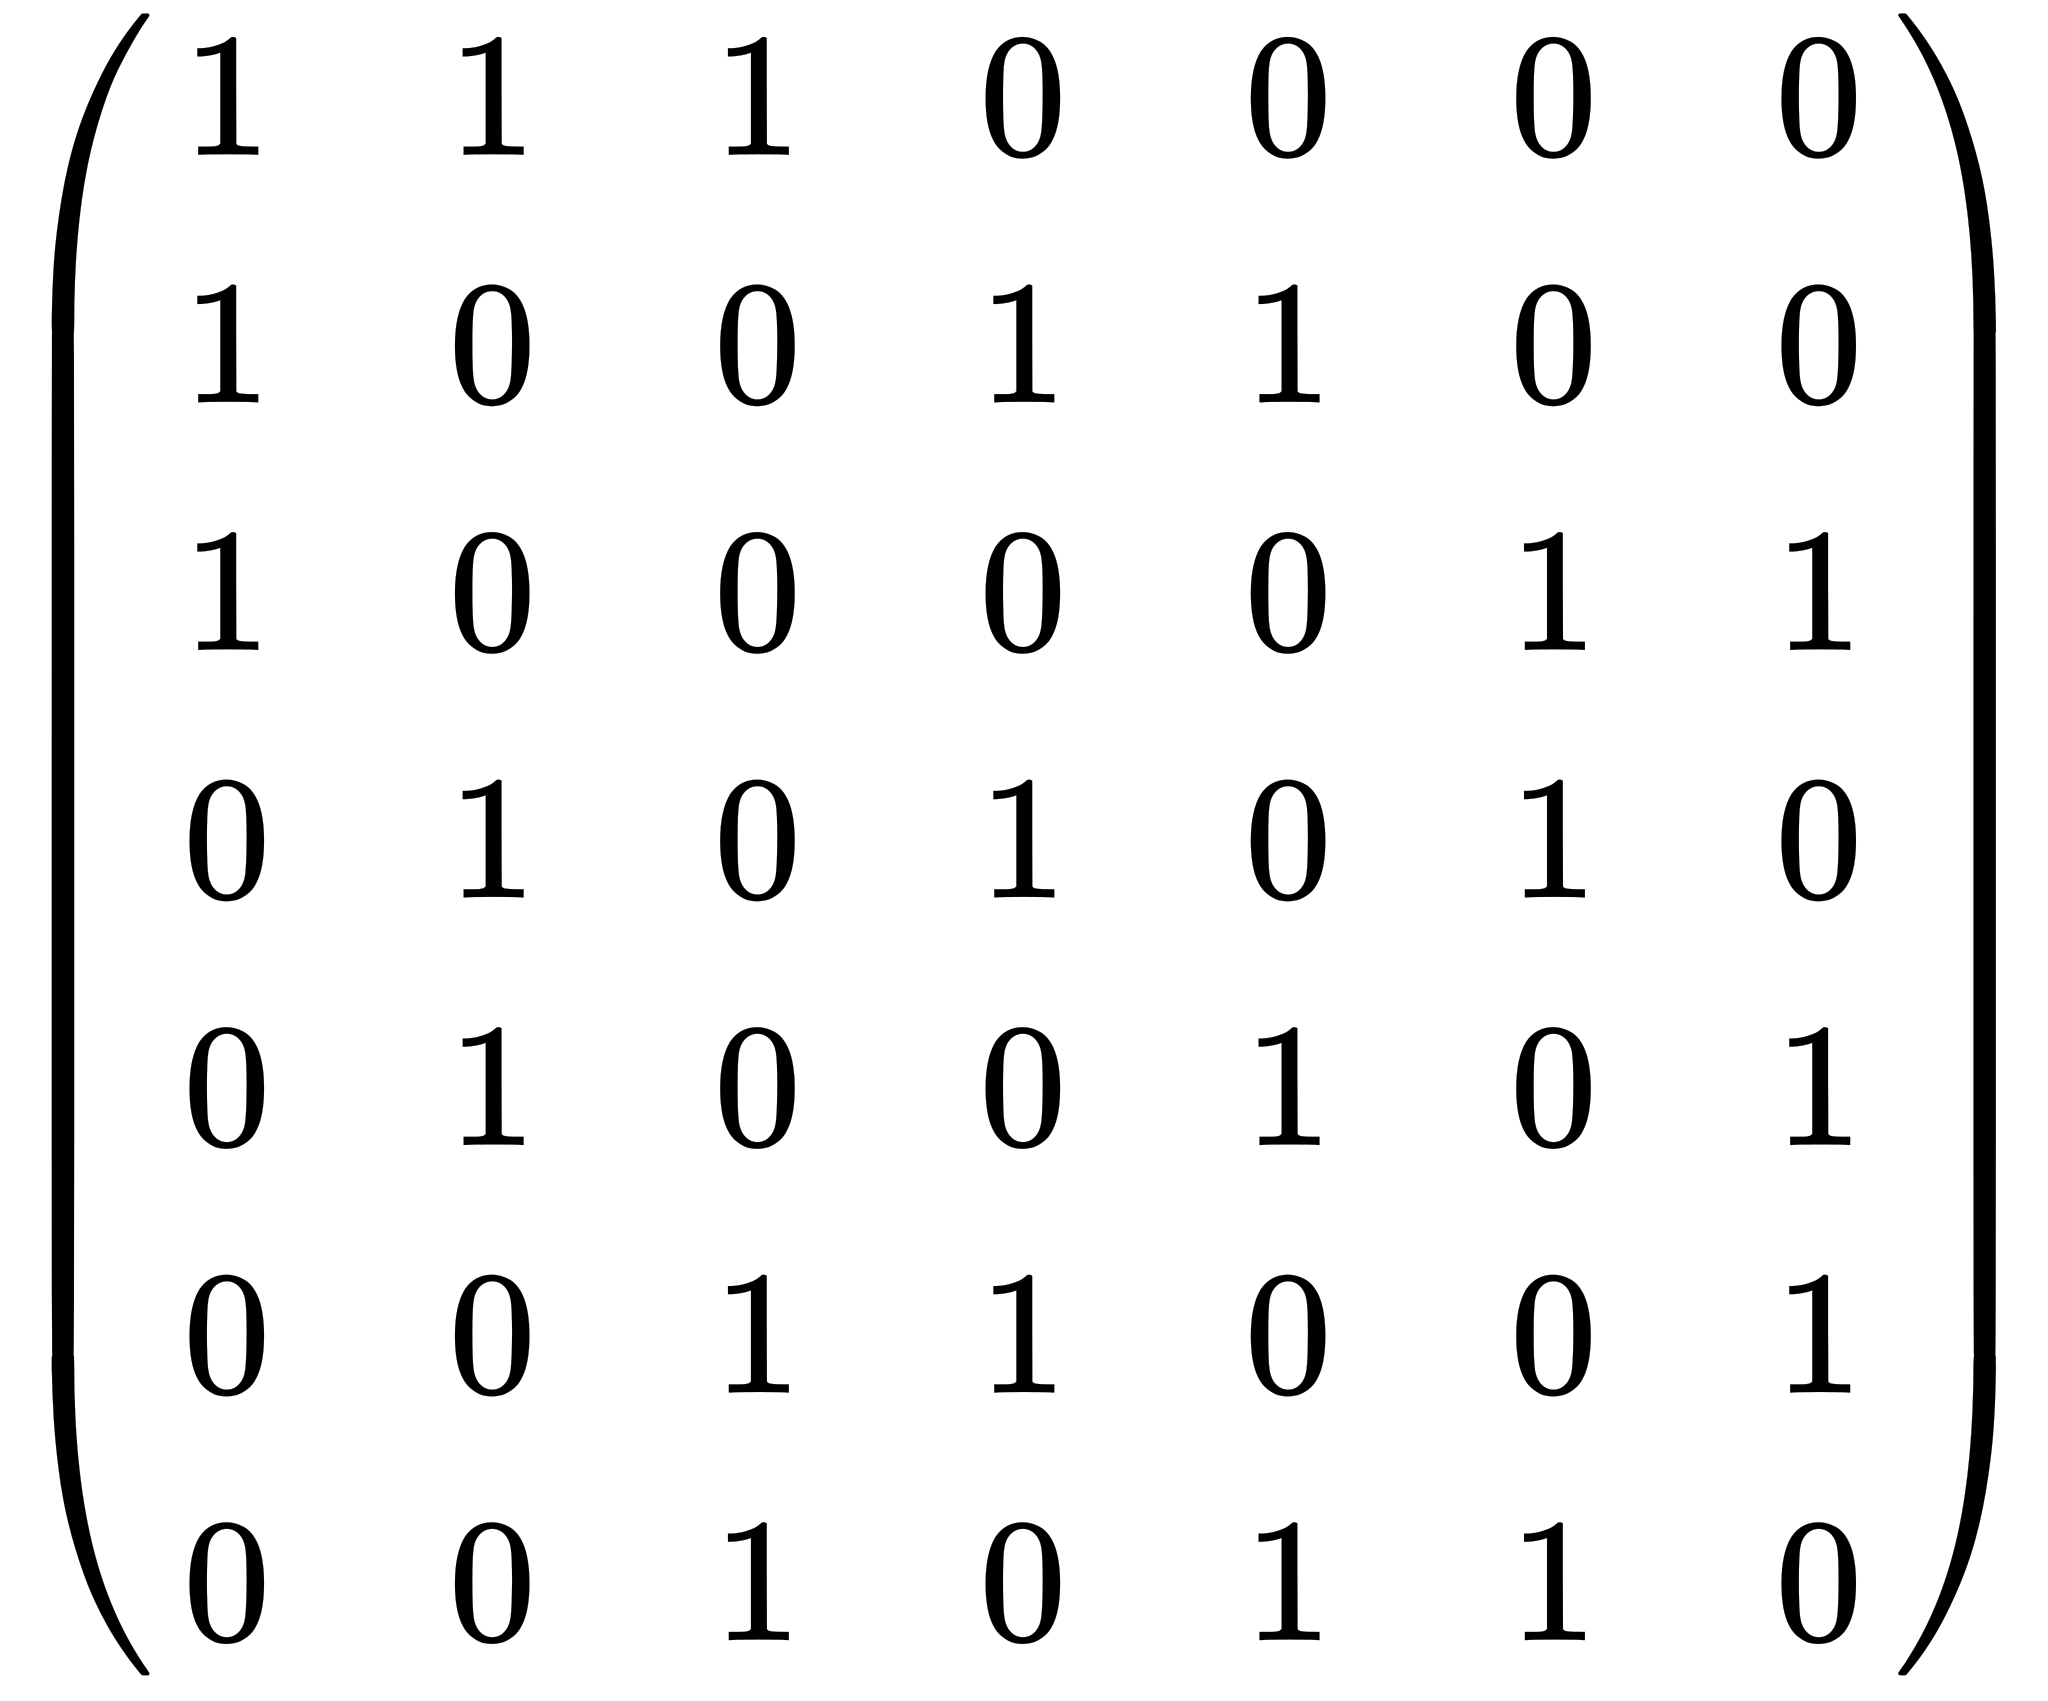

In [2]:
#questo è il più semplice esempio di piano proiettivo possibile (n=2), detto piano di Fano in onore al matematico italiano che l'ha scoperto. 
url <- "https://wikimedia.org/api/rest_v1/media/math/render/svg/62c5311904fc2ab30d952d91d750c915fd6028de"
curl_download(url = url, destfile = "matrice_fano.svg")
display_svg(file = "matrice_fano.svg") #il display di IRdisplay è scarso rispetto a quello di python, devo per forza scaricare l'immagine
#se le colonne rappresentano le rette e le righe i punti (va bene anche il contrario, come detto sopra i piani finiti sono schemi a blocchi bilanciati, incompleti e *simmetrici*) questa matrice ci dice che ad esempio P_1 giace sulle rette r_1, r_2, r_3 e basta (com'è giusto che sia visto che n=2: ogni retta/punto deve essere incidente con n+1=3 punti/rette).

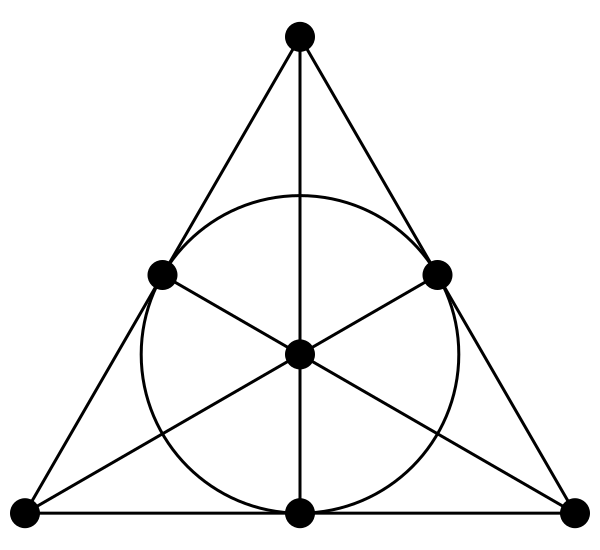

In [3]:
#questa è una rappresentazione grafica del piano di Fano
url <- "https://upload.wikimedia.org/wikipedia/commons/a/af/Fano_plane.svg"
curl_download(url = url, destfile = "fano.svg")
display_svg(file = "fano.svg")
#se consideriamo i 3 punti più a sinistra è ragionevole che la retta passante per il lato sinistro del triangolo li attraversi (e così per gli altri lati), ma quando arriviamo a considerare la terna dei punti associati alle mediante notiamo che è impossibile costruire una retta così come la immaginiamo di solito passante per questi 3 punti, quindi si ricorre ad un cerchio. Cercando su internet rappresentazioni di geometrie di ordine superiore le "rette" diventano sempre più/sempre più spesso curve!

# Campi finiti e costruzione esplicita del piano per $n=p^m$ con $p$ primo ed $m=1$
## Il piano di Dobble: $n=7$
Consideriamo il piano finito con $n=7$ (sicuramente possibile visto che 7 è un numero primo). Tale piano presenta 8 punti per retta e $7^2+7+1=49+8=57$ punti e rette in totale; se associato ogni carta ad una retta e ogni figura ad un piano evidentemente *abbiamo trovato il mazzo di Dobble!* Infatti questo mazzo stando al manuale presenta "55 carte, più di 50 figure, 8 figure per carta" - quindi possiamo supporre che le figure siano effettivamente 57, che per qualche motivo non includano altre 2 carte possibili e più in generale che sia questa la relazione che leghi questi numeri. Propongo adesso una dimostrazione costruttiva (anche se non completamente generale/consapevole di cosa stia succedendo) di come si costruisca la matrice di incidenza/schema a blocchi per questa geometria e anche della formula $N=n^2+n+1$ vista prima (la dimostrazione menzionata prima si basa sul calcolo combinatorio applicato alle possibili righe/colonne di uno schema); si noti che in quanto segue c'è una discreta dose di originalità, quindi potrebbe essere tutto sbagliato e raccomando criticità extra.
## Campi finiti 
Riflettendo un po' sul codice presente in [questa pagina](https://stackoverflow.com/questions/27492822/python-spot-it-cards) e sulla sezione vector space construction [di questa](https://en.wikipedia.org/wiki/Projective_plane) mi sono convinto che un piano finito non sia solo un insieme "analogo" ad un piano infinito (nel senso che è possibile fare rispettare loro gli stessi assiomi), ma che possa essere preso alla lettera - cioè che si possano effettivamente costruire i suoi punti considerando terne ordinate di numeri (coordinate omogenee) e lavorando con gli spazi vettoriali in maniera assolutamente analoga a quanto visto sopra, con l'unica differenza che *lo spazio vettoriale $K^3$ a cui appartengano i punti sia costruito su di un campo finito/di Galois $K$*, contenente un numero finito di elementi (il che implica banalmente che le coordinate di un punto debbano essere discrete). Questo è molto interessante perché da un lato permette una visione intuitiva di un piano finito come "immerso" in quello infinito (con i punti di quello finito "campionati" in modo discreto lungo una griglia di quello infinito), e dall'altro suggerisce un algoritmo per costruire la matrice di incidenza che cerchiamo. 

In [6]:
#cella che non ho tradotto da python perché tanto non la uso 

#se il pacchetto sage è installato questa cella (presa da https://stackoverflow.com/questions/27492822/python-spot-it-cards) produce la matrice cercata! (io personalmente al momento non ce l'ho, quindi metto un try except con pass)
#try :
#    import sage
#
#    sol = sage.combinat.designs.block_design.projective_plane(7)
#
#    for row in sol.incidence_matrix().rows():
#        print(row)
#except :
#    pass 

## Campi finiti (continuo)
Sono andato a scavare un po' nel sorgente su GitHub della funzione chiamata nella cella qui sopra; ho trovato che questa non fa altro che controllare che il suo argomento non sia un numero "proibito" e poi chiama un'altra funzione, che ne chiama un'altra chiamata FiniteField(...) o qualcosa del genere. La buona notizia è che questo conferma quanto sopra (cioè che il nostro piano possa essere costruito come uno spazio vettoriale su un piano finito), la cattiva è che non ci ho capito più niente perché giustamente c'era un labirinto di funzioni e mi sono seccato.     
Torniamo al punto di partenza e cerchiamo un po' come siano fatti questi campi finiti (che com'è ovvio sono dei campi dotati di un numero finito di elementi). [Questa pagina](https://it.wikipedia.org/wiki/Campo_finito) dice un po' di cose interessanti: innanzitutto conferma che si possono sempre costruire campi finiti contenenti $p^m$ elementi con $p$ primo mentre per altri valori in generale non si sa (il che forse è una dimostrazione alternativa del risultato menzionato prima, basato invece sulle equazioni dei vincoli degli schemi a blocchi),, ma soprattutto conferma quanto menzionato alla fine del post su StackOverflow di cui sopra - vale a dire che *quando $m=1$ il campo contenente $p^m=p$ elementi può essere identificato con $\mathbb{Z}/p\mathbb{Z}$*. Se $m\geq 2$ l'insieme degli interi modulo $p^m$ non è più un campo ma solo un anello, e quindi questo isomorfismo non funziona e si deve usare una procedura molto più complicata di cui non ho capito molto per costruire questo campo; fortunatamente a noi interessa $n=p=7$, quindi nel nostro caso ci basta considerare il campo finito $K={0,1,2,3,4,5,6}$ formato da $n=p=7$ elementi.     

## Algoritmo e dimostrazione di $N=n^2+n+1$
### Dimostrazione
Dobbiamo dunque costruire i punti del nostro insieme in modo tale che le tre coordinate omogenee appartengano a $K=\mathbb{Z}/7\mathbb{Z}$ - cioè siano interi compresi fra 0 e 6. Se ciascuna delle 3 coordinate di un punto può assumere 7 valori indipendentemente dalle altre allora apparentemente il nostro insieme contiene $7*7*7=7^3=343$ punti; in realtà, però, molti di questi vanno eliminati ricordando quanto detto all'inizio sulle coordinate omogenee e spingendo fino in fondo l'analogia con il piano infinito. Ricordiamo infatti due proprietà salienti:
- alla terna $(0,0,0)$ non si associa nessun punto, quindi in realtà dovremmo considerare $p^3-1=342$ punti "accettabili";
- le coordinate omogenee sono definite a meno di uno scalare arbitrario. Questo significa che data una generica terna $\vec{v}$ i $p-1=6$ vettori $1\vec{v},2\vec{v},3\vec{v},4\vec{v},5\vec{v},6\vec{v}$ (-1 perché ovviamente dobbiamo escludere lo scalare 0 per avere vettori "accettabili") rappresentano lo stesso punto del piano. Ma allora se prendiamo i $p^3-1$ possibili vettori con componenti discrete fra $0$ e $p-1$ non tutte nulle e li dividiamo in gruppi di $p-1$ elementi fra loro *equivalenti* abbiamo che di questi gruppi basta prendere un solo rappresentante; in questo modo avremo una corrispondenza biunivoca fra vettori di coordinate omogenee e punti. In particolare questo significa che dobbiamo prendere solamente
\begin{equation}
\frac{p^3-1}{p-1} \ \text{gruppi} \cdot 1 \ \text{elemento/gruppo} = p^2+p+1
\end{equation}
dove l'ultimo membro è un conto che ho fatto io dividendo i polinomi con Ruffini.    
Credo che questo almeno nel caso semplice considerato basti a dimostrare la formula menzionata più volte (ma questa dimostrazione è interamente farina del mio sacco, quindi boh) e a spiegare quale algoritmo costruire! 
### Algoritmo parte 1: costruzione dei punti del piano finito
Dobbiamo effettuare quello che in termini formali potremmo descrivere come *prendere il quoziente dell'insieme delle disposizioni con la relazione di equivalenza vista prima* (cioè quella che sottindendiamo quando diciamo che vettori con coordinate proporzionali sono equivalenti). Per effettuare questa "scrematura" possiamo procedere così:
- Costruiamo tutte le $p^3$ terne possibili di interi compresi fra $0$ e $p-1$; in altri termini costruiamo il prodotto cartesiano $K^3$.
- Eliminiamo il vettore $(0,0,0)$ dall'insieme di cui sopra;
- scorrendo lungo i $p^3-1$ punti rimasti calcoliamo l'insieme di equivalenza di ciascuno scegliendo un rappresentante; questo significa che data una terna $\vec{v}$ calcoliamo i $k\vec{v}$ con $k\in K\setminus \{0\}$, cioè $1\vec{v},2\vec{v},3\vec{v},\dots,5\vec{v}$, e salviamo solo il primo di questi;
- eliminiamo i doppioni.     
          
Gli ultimi due punti servono a rimpiazzare ogni terna con ad esempio la più piccola terna ad essa equivalente. Ad esempio se il nostro insieme iniziale di vettori di $K^3$ contiene $(1,1,1),(2,2,2),(3,3,3)$ per ciascuno di questi calcoleremo gli altri e terremo solo $(1,1,1)$, in modo tale da avere 3 copie di $(1,1,1)$ (due delle quali saranno dunque eliminate dall'ultimo punto dell'algoritmo).
### Algoritmo parte 2: calcolo della matrice di incidenza
Che si fa una volta trovato l'insieme dei $p^2+p+1$ vettori che possono adesso essere identificati come punti del piano di ordine p? Procediamo come segue. Come sappiamo una retta può essere identificata con un qualunque vettore ad essa perpendicolare; un vettore che soddisfa queste caratteristiche è quello con componenti pari ai coefficienti della retta (come si dimostra facilmente sfruttando le coordinate omogenee). Se un punto giace su quella retta allora ne soddisfa l'equazione, e pertanto il vettore di componenti pari alle coordinate del punto dovrà essere perpendicolare al vettore perpendicolare alla retta (risultato ovvio se si scrive l'equazione della retta come prodotto scalare fra questi due vettori). Abbiamo così (forse) riscoperto in piccolo la dualità menzionata nelle pagine citate: se una retta può essere individuata dal vettore/punto perpendicolare e quest'ultimo non può che essere uno dei possibili punti (in numero finito) del nostro piano abbiamo che *ogni punto individua una retta* (simmetria, dualità, corrispondenza 1:1 fra piani e rette menzionata prima ma non ben capita da quelle pagine) e che *possiamo considerare incidenti un punto e una retta se il punto e il punto/vettore della retta sono ortogonali*. 
Per concludere l'algoritmo, dunque, ci basta costruire tutte le possibili coppie $(i,j)$ di punti e piazzare un 1 nell'elemento $(i,j)$ della matrice se il prodotto scalare fra quei punti fa zero.
### Nota importante
Il prodotto scalare fra vettori di $V(K)$ è una applicazione da $V\times V$ in $K$, quindi nel nostro caso il prodotto scalare non è appena la somma dei prodotti delle componenti ma quella quantità *modulo p*!

In [7]:
#traduzione di incidence_matrix_numpy() scritta da me nella versione python
incidence.matrix <- function(p = 7){
    points <- matrix(0, nrow = p^3, ncol = 3)
    i <- 1 #occhio che in R il secondo estremo è compreso!
    for (a in 0:(p-1)){
        for (b in 0:(p-1)){
            for (c in 0:(p-1)){
                #print(i)
                points[i,1:3] <- c(a,b,c) #tutte le possibili terne di interi compresi fra 0 e p-1
                i <- i+1 #soluzione non troppo elegante ma non mi va di aggiungere un altro for. Se no serve un append
            }
        }
    }#questi "points" sono in realtà gli elementi di V=K^3, che uso sia per costruire i punti veri che le rette mediante i vettori loro normali
    points <- points[2:(p^3),1:3] #escludo la prima riga, cioè (0,0,0) in quanto questa terna non è associata ad alcun punto
    
    #nella funzione seguente ho bisogno di ordinare le righe di una matrice secondo un criterio univoco in modo da poter prendere un unico rappresentante per ogni classe di equivalenza.
    #Quale prendiamo non è importante, è importante che lo stesso criterio sia usato costantemente per garantire coerenza. Non sto trovando un analogo soddisfacente di sorted + il __cmp__ del 
    #tipo tuple di python, quindi lo emulo con una porcheria di codice. In python due tuples vengono confrontate con la seguente gerarchia: se il primo elemento è diverso si prende il minore/maggiore
    #(a seconda di come avvenga il sorting), se è uguale si guarda al secondo e così via. Nella funzione seguente faccio lo stesso: guardo quante volte è ripetuto nella prima colonna il minimo di
    #tale colonna e se c'è una volta sola restituisco la riga dove si trova (non mi interessa un sorting completo); altrimenti passo alla seconda colonna e alla terza se necessario 
    #(hardcoding + codice ripetuto, disgusto puro)
    obtain.first.sorted.row <- function(y){
        if (sum(y[,1] == min(y[,1])) == 1){ #sum di numeri che sono o 0 o 1 è equivalente a count_nonzero (mi secco a importare pezzi della libreria Matrix per così poco)
            return(y[which.min(y[,1]),] )
        }
        else {
            if (sum(y[,2] == min(y[,2])) == 1){
                return(y[which.min(y[,2]),])
            }
            else {
                return(y[which.min(y[,3]),])
            }
        }
    }
    #un sorting di questo tipo è inevitabile, altri criteri come ad esempio la minimizzazione della somma/media calcolata per righe non sempre dà il risultato voluto (cfr il vettore c(0,1,4))
    
    canonise <- function(x){
        y <- matrix(x, nrow = (p-1), ncol = 3, byrow = T) #crea delle copie di x, una per riga (rep mi dà un vettore, non una matrice). Fondamentale mettere byrow True, se no la matrice viene costruita copiando x lungo le colonne anziché le righe!
        y <- y * 1:(p-1) #prodotto row-wise in modo da moltiplicare ogni copia di x per 1,2,...,p-1
        y <- y %% p #poiché stiamo lavorando in K^3 componenti non in K sono vietate, prendiamo di nuovo il modulo
        #adesso effettuiamo il sorting delle righe. Poiché non sto trovando un metodo analogo a python soddisfacente faccio così:
        #poiché mi interessa la riga minore (nel senso che ha i 3 elementi minori rispetto ai corrispondenti elementi delle altre righe)
        #mi basta prendere la riga la cui media/somma è minima
        y <- obtain.first.sorted.row(y)
        #print(x)
        #print(y)
        return(y)
    }
    
    N <- dim(points)[1]
    for (i in 1:N){
        points[i,] <- canonise(points[i,]) #rimpiazzo ogni vettore con la sua versione "canonizzata", cioè con il suo equivalente minimo
    }
    #se adesso rimuovo i doppioni ottengo infine i vettori che rappresentano senza ambiguità i punti.
    points <- unique(points) #mi dà le righe uniche
    
    N <- dim(points)[1] #va ricalcolato perché adesso N è minore rispetto a prima causa rimozione duplicati
    #return(points)
    imatrix <- matrix(0, nrow = N, ncol = N) #se c'è una funzione zeros non è presente senza librerie extra tipo Matrix, e alla fine se matrix ingloba rep va bene così
    for (i in 1:N){
        for (j in 1:N){
            imatrix[i,j] = sum(points[i,]*points[j,]) #se c'è una funzione per il prodotto scalare è abbastanza inaccessibile da farmi perdere più tempo a cercarla che a replicarla da me
        }
    }
    imatrix <- imatrix %% p
    posti.dove.mettere.1 <- imatrix == 0
    posti.dove.mettere.0 <- imatrix != 0
    imatrix[posti.dove.mettere.1] <- 1
    imatrix[posti.dove.mettere.0] <- 0
    return(imatrix)
    
}

incidence.matrix()

0,1,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,1,0,0,0,0,0
0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
0,0,0,0,0,0,1,0,1,0,...,1,0,0,0,0,1,0,0,0,0
0,0,0,0,0,1,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
0,0,1,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
1,1,1,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


# Costruzione del mazzo
Abbiamo quasi finito! Abbiamo capito come costruire il mazzo, perché un mazzo con 8 figure per carta sia composto da 57 figure spalmate su al più 57 carte e così via; resta da vedere se la matrice di incidenza appena calcolata sia capace di produrre effettivamente il mazzo di carte di dobble.        
Prima di verificare se il mazzo che costruiamo con questa matrice sia corretto vediamo come tradurre la matrice di incidenza in un mazzo; procediamo come segue. Innanzitutto osserviamo che [questo adorabile sito](https://www.markporthouse.net/spot-it-dobble-symbol-list) riporta per noi le 57 figure presenti nel gioco; con l'aiuto di `urllib3` e `re` possiamo scaricare la pagina web e compiere una magia con le *regular expressions* in modo da estrarre una lista delle 57 figure del gioco (creo anche un dizionario per contarle, in modo da poter verificare che otteniamo effettivamente una copia della lista presente sul sito). 
Una volta che abbiamo la nostra lista di figure costruiamo il mazzo trattandolo come una lista di liste, dove ogni lista "interna" dovrà contenere 8 stringhe in modo da poter rappresentare una carta; per farlo facciamo un doppio loop for nested (mediante list comprehension) così:
- iteriamo "esternamente" sulle righe della matrice;
- fissata una riga della matrice facciamo un altro loop sulle 57 coppie che si ottengono (mediante `zip`) accoppiando ordinatamente ciascuna delle 57 figure con ciascuno dei 57 bit presenti nella riga considerata;
- in questo loop interno ogni volta che troviamo un bit intero effettuiamo l'appending della sua figura alla lista considerata, altrimenti non facciamo niente.
(Si può fare for... for... if, ma con una doppia list comprehension è tutto più veloce).        
Implementiamo quanto sopra; poi verificheremo la correttezza del risultato.

In [8]:
#url <- "https://www.markporthouse.net/spot-it-dobble-symbol-list"
#webpage <- getURL(url)
#grep("[1-5]*[0-9]+\\. ([A-Z][a-z]+’* *[a-z]* *[A-Z]*[a-z]* *[a-z]* *[a-z]*)", webpage, value = TRUE) #R è l'unico linguaggio al mondo dove serve il double escape...

#non funziona un cavolo e non ho voglia di perdere tempo su cose che dovrebbero funzionare subito come in python... è ora di barare
system("python regex.py") #esegue lo script che crea il file figure.txt
figure <- scan("figure.txt", what = character(), sep = "\n") #legge questo file e quindi trova le figure
names(figure) <- 1:length(figure)
figure

[1] 0

1                        2                        3 
                "Anchor"                  "Apple"            "Baby bottle" 
                       4                        5                        6 
                  "Bomb"                 "Cactus"                 "Candle" 
                       7                        8                        9 
              "Taxi car"                 "Carrot"           "Chess knight" 
                      10                       11                       12 
                 "Clock"                  "Clown"           "Diasy flower" 
                      13                       14                       15 
              "Dinosaur"                "Dolphin"                 "Dragon" 
                      16                       17                       18 
     "Exclamation point"                    "Eye"                   "Fire" 
                      19                       20                       21 
      "Four leaf clover"                  "Ghost"           "Green splats" 
                      22                       23                       24 
                "Hammer"                  "Heart"               "Ice cube" 
                      25                       26                       27 
                 "Igloo"                    "Key"              "Ladybird " 
                      28                       29                       30 
            "Light bulb"         "Lightning bolt"                   "Lock" 
                      31                       32                       33 
            "Maple leaf"                   "Moon"          "No Entry sign" 
                      34                       35                       36 
  "Orange scarecrow man"                 "Pencil"            "Purple bird" 
                      37                       38                       39 
            "Purple cat" "Purple dobble hand man"               "Red lips" 
                      40                       41                       42 
              "Scissors"   "Skull and crossbones"              "Snowflake" 
                      43                       44                       45 
               "Snowman"                 "Spider"           "Spider’s web" 
                      46                       47                       48 
                   "Sun"             "Sunglasses"                 "Target" 
                      49                       50                       51 
              "Tortoise"            "Treble clef"                   "Tree" 
                      52                       53                       54 
            "Water drip"                    "Dog"           "Yin and Yang" 
                      55                       56                       57 
                 "Zebra"          "Question mark"                 "Cheese"

In [9]:
imatrix <- incidence.matrix()
N <- length(figure) #è 57 #numero di figure = uguale al numero di righe/colonne nella matrice ma in questo caso è inutile implementare un check
n.figure.per.carta <- 8
mazzo <- matrix(" ", nrow = N, ncol = n.figure.per.carta) #anziché una lista di liste creo una matrice di caratteri (sono senza list comprehension qui)

for (i in 1:N){ #loop sulle righe della matrice
    k <- 1 #i e j devono arrivare fino a 57 perché mi servono per leggere imatrix, ma mazzo ha solo 8 colonne e pertanto uso un indice temporaneo del cavolo per tenere traccia di questo
    for (j in 1:N){ #qua la riga della matrice è fissata (loop sulle colonne), e posso usare un unico indexing (al posto di zip in python) per leggere il bit di utilizzo e la figura corrispondente
        if (imatrix[i,j]){ 
            mazzo[i,k] <- figure[j] #qui voglio j e non i perché mi serve l'indice accoppiato al bit di utilizzo dello dalla matrice di incidenza
            #print(sprintf("%d, %d",i,j))
            k <- k+1
        }
    }
}
mazzo

Apple,Chess knight,Exclamation point,Heart,Lock,Purple cat,Spider,Tree
Anchor,Chess knight,Clock,Clown,Diasy flower,Dinosaur,Dolphin,Dragon
Carrot,Chess knight,Hammer,Light bulb,Orange scarecrow man,Scissors,Sun,Water drip
Cactus,Chess knight,Four leaf clover,Lightning bolt,Moon,Snowflake,Spider’s web,Zebra
Bomb,Chess knight,Fire,Ladybird,Purple bird,Purple dobble hand man,Sunglasses,Question mark
Taxi car,Chess knight,Green splats,Key,Maple leaf,Snowman,Target,Dog
Candle,Chess knight,Ghost,Ice cube,Pencil,Red lips,Treble clef,Yin and Yang
Baby bottle,Chess knight,Eye,Igloo,No Entry sign,Skull and crossbones,Tortoise,Cheese
Anchor,Apple,Baby bottle,Bomb,Cactus,Candle,Taxi car,Carrot
Apple,Dragon,Hammer,Lightning bolt,Purple bird,Snowman,Treble clef,Cheese
Apple,Diasy flower,Four leaf clover,Key,No Entry sign,Scissors,Sunglasses,Yin and Yang


# Verifica della correttezza del mazzo ottenuto
## Note tecniche (ingora questa sezione nella versione in R del notebook)
Le due funzioni restituiscono matrici differenti e di conseguenza i due mazzi costruiti sopra non sono banalmente identici. Questo ovviamente non è un problema; se sono presenti le stesse carte ma in ordine diverso siamo comunque a posto. Per verificare se le due funzioni siano effettivamente equivalenti in questo senso possiamo dunque fare questa verifica, ad esempio utilizzando set anziché liste per vedere se i mazzi contengano le stesse carte; questa verifica è però non banale perché liste/array non sono hashable e quindi non banalmente castabili a set, e anche se facessi il casting lista di liste-->lista di tuples-->set di tuple (lecito, le tuples sono hashables) avrei comunque il problema che tuples contenenti gli stessi elementi ma in ordine diverso sono diverse, e quindi dovrei tenerne conto (set di set = vietati in quanto anche i set non sono hashables). Alternativa più semplice: torniamo alle matrici e vediamo se contengono le stesse righe/colonne disposte in modo diverso - ma siccome non ho voglia di scrivere codice su permutazioni faccio una cosa ancora più semplice, cioè verifico separatamente se le due matrici siano corrette (cosa che devo comunque fare, perché due funzioni sbagliate allo stesso modo sono comunque sbagliate...!).                   
## $n^2-n$ è il numero della verifica (dimostrazione e algoritmo)
Procediamo come segue (è un ragionamento che ho elaborato da me, prendere con le pinze). Supponiamo di avere due mazzi identici formati da $n$ carte e di volere creare tutte le possibili coppie formate da una carta del primo mazzo e una carta del secondo. La prima carta delle $n$ carte del primo mazzo può essere accoppiata con la prima del secondo, la seconda del secondo, la terza del secondo e così via fino alla carta $n$ del secondo mazzo per un totale di $n$ possibili coppie del tipo $(1,i)$ con $i \in [1,n]$. Lo stesso vale per la seconda carta del primo mazzo ($n$ coppie) e così via, fino alla carta $n$ del primo mazzo; abbiamo quindi $n*n=n^2$ accoppiamenti possibili costruiti in questo modo. Se adesso anziché costruire le coppie con due mazzi identici le costruiamo lavorando con un unico mazzo abbiamo che tutte le coppie del tipo $(i,i)$ non sono più possibili perché adesso ho una sola copia di una data carta; pertanto poiché date $n$ carte possiamo costruire $n$ 2-uple di questo tipo abbiamo che il numero di coppie possibili è $n^2-n$.        
Come sappiamo in dobble presa una arbitraria coppia di carte (necessariamente distinte) queste avranno una e una sola figura in comune, quindi affinché il codice sia corretto è necessario che se contiamo tutti i match di figure fra coppie di carte distinte otteniamo esattamente $n^2-n$ "successi". Procediamo allora come segue:
- facciamo un loop "esterno" sul mazzo;
- facciamo un altro loop "interno" sul mazzo;
- se le due carte di una generica iterazione sono distinte scorriamo lungo le figure della prima con un terzo loop;
- se la figura del terzo loop è presente nella seconda carta incrementiamo di 1 un contatore;
- stampiamo il valore finale del contatore.
I primi due loop servono a costruire tutte le possibili coppie, il primo if a scartare le coppie illecite (cioè formate da carte uguali, che nel mazzo di dobble non sono presenti), infine l'ultimo loop con if verifica se la figura considerata sia effettivamente presente in entrambe le carte.      

Poiché il mazzo di dobble è formato da 57 carte (stiamo contando anche le 2 carte assenti dalla confezione per qualche motivo) ci aspettiamo che se il codice è corretto (e se lo è anche il ragionamento esposto qui sopra) l'algoritmo di cui sopra restituisca $57^2-57=3192$. Verifichiamolo!

## Dimostrazione alternativa di $n^2-n$
Ciò che ci interessa è contare quante coppie sia possibile creare utilizzando un mazzo di $n=57$; questo significa che possiamo utilizzare la formula delle combinazioni semplici (cioè senza ripetizione) con $k=2$.
In generale si has
\begin{equation}
C_{n,k} = \frac{n!}{k!(n-k)!}
\end{equation}
Nel nostro caso ($k=2$) questa relazione diventa:
\begin{equation}
C_{n,2} = \frac{n!}{2!(n-2)!} = \frac{n(n-1)(n-2)!}{2(n-2)!} = \frac{1}{2}n(n-1)=\frac{1}{2}(n^2-n)
\end{equation}
Abbiamo ottenuto lo stesso valore di prima a meno di un fattore $1/2$ - giusto! Infatti nella dimostrazione precedente non ci siamo preoccupati di eliminare dal computo le permutazioni di una stessa coppia, e pertanto si ha che ad esempio la coppia $(1,3)$ è distinta dalla coppia $(3,1)$ anche se fisicamente si tratta della stessa coppia (essendo il mazzo unico). Tuttavia entrambi i modi di contare sono egualmente validi, purché si mantenga coerenza; se ad esempio utilizziamo le combinazioni semplici di cui sopra e nell'algoritmo per contare eliminiamo i doppioni va bene, ma va bene anche se non eliminiamo i doppioni e utilizziamo il doppio del risultato.       
È chiaro che implementare nel codice di cui sopra una rimozione dei doppioni è una seccatura inutile e inefficiente visto che abbiamo una formula analitica (visto che una coppia ammette un'unica permutazione basta contare distinguendo le permutazioni e dividere per 2 il risultato), ma è chiaro che utilizzando quest'ultima dobbiamo semplicemente dividere per 2 sia il contatore che il nostro valore di 3192 - palesemente superfluo, quindi nel codice seguente utilizzo il modo "superfluo" a sua volta di contare le coppie.

In [10]:
x <- 57**2-57
s <- sprintf("Se è tutto giusto dobbiamo ottenere %d accoppiamenti di una stessa figura su due carte distinte!",x)
print(s)

[1] "Se è tutto giusto dobbiamo ottenere 3192 accoppiamenti di una stessa figura su due carte distinte!"


Nota a posteriori: probabilmente sono stato un po' troppo duro con R, pare che anche in R si possa usare qualcosa come il for i in iterable di python - nel qual caso la cella seguente diventa cento volte più leggibile in quanto non serve indexing di sorta. Ops! Ma ormai mi secco a cambiarla. cfr python per vedere quale fosse la mia intenzione originale

In [11]:
#non molto elegante ma semplice e funzionante. cfr con la versione in python per apprezzare la semplicità e il potere di sintesi di python
contatore <- 0
#il loop con l'indexing anziché "in" di python è un po' meno leggibile. Dobbiamo fare un doppio loop nested, entrambi sono sulle carte del mazzo (cioè sulle righe della matrice);
#pertanto stavolta i e j sono un doppio indice di riga

n.carte <- dim(mazzo)[1] #sempre 57, ma così è più chiaro
n.figure.per.carta <- 8

for (i in 1:n.carte) { #indice della carta 1
    for (j in 1:n.carte) { #indice della carta 2
        #nell'if seguente non posso usare == direttamente causa vettori di lunghezza > 1 (è stupido e non capisce subito che voglio il bitwise, dice che usa solo il primo)
        #allora devo usare identical() con num.eq falso in modo che utilizzi il bitwise. Non posso negare direttamente con ! e certo non esiste il not, quindi devo fare 
        #la porcheria di mettere un == FALSE finale...!
        if ((identical(mazzo[i,], mazzo[j,], num.eq = FALSE)) == FALSE) {#con questa riga e le due precedenti costruisco tutte le possibili coppie di carte distinte
            for (k in 1:n.figure.per.carta) {#indice delle figure nella carta 1
                for (l in 1:n.figure.per.carta) {#indice delle figure nella carta 2. Sicuramente almeno qui posso fare giochi con %in% analoghi all'in di python, ma mi secco a starci altro tempo
                    if(mazzo[i,k] == mazzo[j,l]) {#considero una ad una le figure nella carta 1
                        contatore <- contatore+1#verifico se la figura considerata si trovi anche nella carta 2   
                    }
                }
            }
        }      
    }
}

print(sprintf("Accoppiamenti contati: %d",contatore))

# un commento a posteriori: ho scoperto che effettivamente per qualche motivo in R l'if non è vettorizzato, mentre ifelse lo è (ma ormai mi secco a cambiare il codice e in ogni caso dovrei fare qualche giro del cavolo per "riempire" l'else)

[1] "Accoppiamenti contati: 3192"


# Conclusioni
Abbiamo visto come con la giusta combinazione di matematica sia possibile svelare il mistero di dobble. In particolare:
- passando a coordinate omogenee e aggiungendo i punti impropri del piano ogni retta ha sempre uno e un solo punto in comune con ogni altra, quindi associando carte a rette e figure a punti possiamo costruire la proprietà fondamentale del mazzo di dobble;
- passando da una geometria infinita ad una finita "discretizziamo" carte e figure, ottenendo anche le leggi che spiegano le 57 carte/figure eccetera;
- costruendo concretamente la geometria di cui sopra mediante uno spazio vettoriale su un campo finito (in particolare sul campo $\mathbb{Z}/7\mathbb{Z}$ nel nostro caso) otteniamo la matrice booleana di incidenza, che è vera in corrispondenza di righe e colonne (cioè punti e rette) che si toccano;
- utilizzando la matrice di cui sopra costruiamo un mazzo mettendo su ogni carta la figura che si trova in corrispondenza degli 8 1 presenti nei 57 valori di una data riga/colonna della matrice di incidenza.
Forte!                 

## Ancora una nota per il lettore
Per favore non ti fidare delle cose che ho elaborato con la mia testa (intendo sia le dimostrazioni fatte in casa che le fonti poco comprese e assemblate male), dove mancano fonti o dico di non averle capite valuta autonomamente - e se scopri qualcosa fammelo sapere!

# Qualche commento
Parlando con Luigi e ascoltandone le perplessità mi sono accorto della necessità di aggiungere qualche commento extra.
## Simmetria nella condizione di ortogonalità
### Dualità fra punti e rette e il ruolo dello spazio vettoriale $V(K)$
Leggendo le varie fonti ho capito che c'è una simmetria profonda costruita nelle fondamenta della geometria finita - in particolare si tratta di una dualità, una corrispondenza 1:1 fra punti e rette e che spiegherebbe perché ad esempio ci sono $n^2+n+1$ punti *e* rette, perché ogni retta incida con $n+1$ punti e ogni punto incida con $n+1$ rette e così via. Non mi so spiegare benissimo questa dualità né l'ho capita, però credo che emerga in modo naturale nella costruzione esplicita fatta sopra della geometria finita - per i seguenti motivi. Si consideri il nostro spazio vettoriale $V=K^3$ di elementi in numero finito;tale insieme è stato utilizzato sia per costruire le coordinate dei punti "ammissibili" che per costruire le componenti dei vettori normali alle rette (e quindi a rappresentare queste ultime), e di conseguenza è inevitabile che costruire tutte le possibili coppie di elementi appartenenti a questo spazio vettoriale possa essere interpretato come l'insieme delle coppie punto-punto, punto-retta o retta-retta. In questo senso confondendo vettori con punti possiamo sicuramente dire che nel prodotto scalare fra due punti valutiamo il prodotto fra (il vettore che rappresenta) un punto con (quello che rappresenta) una retta, e pertanto i prodotti di tutte le coppie di elementi di questo insieme danno effettivamente tutte le possibili incidenze fra rette e punti. Ribadisco quanto appena detto perché effettivamente il nome `points` della matrice dei vettori di $V(K)$ è un po' improprio, quindi tanto vale precisare che tecnicamente si tratti solamente dei vettori astratti a cui attingiamo per costruire sia punti che rette.      
### Calcolo della matrice di incidenza e il ruolo della condizione di ortogonalità
Più delicata è la questione della ortogonalità. Si noti che nel calcolo della matrice di incidenza da nessuna parte abbiamo effettivamente implementato il "sudoku" derivante dagli assiomi (non più di un 1 nella stessa posizione per ogni coppia di righe e colonne), ma ci siamo "fidati" del prodotto scalare. Questa operazione è lecita nella misura in cui accettiamo che la geometria finita si comporti in modo analogo a quella infinita (e che quindi il prodotto scalare nullo equivalga all'equazione di una retta soddisfatta), ma presuppone un atto di fede per quanto riguarda il risultato! Infatti senza costruire da zero la nostra matrice cercando di implementare il "sudoku" indipendentemente dalla costruzione dello spazio vettoriale $V$ sul campo finito $K$ tecnicamente non possiamo essere sicuri che gli assiomi verranno rispettati; l'atto di fede è pertanto fidarsi del fatto che ragionando come nella geometria infinita effettivamente otterremo che ogni retta/punto è incidente con $n+1$ rette/punti.        
Non ho una spiegazione soddisfacente di questo punto perché non ho una comprensione decente della costruzione astratta o concreta di questi piani finiti; ho però capito che costruendo lo spazio vettoriale come sopra e facendo finta di essere in una geometria infinita più o meno le cose tornano (sia nel senso che la matrice ottenuta supera i test che ho escogitato sia nel senso che questo formalismo effettivamente mi ha permesso di ricavare la formula $n^2+n+1$ in modo geometrico e che secondo me va bene).               
Ciò che vorrei comunicare al lettore, dunque, è questo: il problema della costruzione dei piani finiti probabilmente si può trattare sia in astratto (costruendo insiemi di oggetti che devono soddisfare degli assiomi in un modo che concretamente si verifica mediante il "sudoku") che in concreto (replicando la costruzione dello spazio vettoriale "di supporto" e attingendo ad esso per costruire rette e punti).

## Un altro piccolo test alla dualità di cui sopra
Che una geometria finita sia di ordine $n$ in coordinate omogenee vuol dire per definizione che ogni punto/retta è incidente con $n+1$ rette/punti. Nel caso di dobble questo significa sia che ci sono 8 punti per retta = 8 figure per ogni carta (cosa che si verifica con uno sguardo), sia che ci sono 8 rette per punto = ogni figura compare su 8 carte (fatto non banale). Quest'ultimo fatto è interessante perché rende possibile il gioco in cui si devono costruire terne anziché coppie di carte con lo stesso simbolo; sulla base della dualità di cui sopra si tratta di un fatto banale e che quasi non richiede verifica, ma se prendiamo per buono che il mazzo costruito sopra sia corretto (cosa che non verificherò mai esplicitamente confrontando con le carte vere) allora possiamo verificare sperimentalmente. Per fare questa verifica ci basta iterare sulle righe/colonne della matrice di incidenza (ogni riga/colonna rappresenta una figura) e contare il numero di 1 presenti in quella data riga (in modo da ottenere su quante carte compaia quella data figura); affinché tutto torni poiché ci sono 8 figure per carta dobbiamo avere che ogni figura compaia su 8 carte, e pertanto possiamo contare quante volte accade che il numero di 1 presenti in una riga/colonna sia 8. Se il risultato di questa operazione è 57 allora ogni riga/colonna della matrice e pertanto ogni figura delle 57 disponibili compare effettivamente su 8 carte!                             
(Anche qui tecnicamente sto barando perché uso la matrice anziché il mazzo, ma visto che si tratta praticamente della stessa cosa va bene).

In [15]:
N <- dim(imatrix)[1] #va bene anche mazzo come argomento di dim, sempre 57 mi serve
contatore <- 0
for (i in 1:N) {
    if (sum(imatrix[i,]) == 8) {
        contatore <- contatore +1
    }
}
print(sprintf("Il numero di figure che compaiono esattamente su 8 carte è %d (su un totale di 57 figure)",contatore))

[1] "Il numero di figure che compaiono esattamente su 8 carte è 57 (su un totale di 57 figure)"
